# Executive Summary

This full example is meant to implement how the digital twin abstract class is supposed to be useful and work. It will show what needs to be done on the model end as well as what gets used on the digital twin abstract class end.

The directory for this model is "model2"

Everything here would be what should be going into a dt.py file that would create the digital twin framework.

# What is the Digital Twin Framework

The framework is an abstract class with convenience functions that is meant to standardize creation of digital twin models. The six major modules of the framework are:

1. Data
2. Backtesting
3. Stochastic Fit
4. Signal Projections
5. Extrapolation
6. Reporting

# Why this Framework

- It allows for more modularity/swapping different pieces of the pipelines
- It allows for extensions in the future
- It standardizes the digital twin model

# Where is the Project Now

A completed V1 template of a digital twin framework with the accompanying example of how to implement a model. 

# Future Developments

1. cadCAD V1 revisions
2. Review process + improvements
3. Extensions for the possibility of KPIs, parameter selection under uncertainty, etc
4. Native data infrastructure connectors
5. Connections to things like cloud functions or other extensions

# Example Summary -  Index Fund Arbitrage

## Introduction

An index fund will hold a basket of assets for some sort of general investment thesis. This allows individuals to buy and sell the index fund shares but essentially "own" the basket instead of needing to form the basket themselves.

Every day, an index fund's NAV, Net Asset Value, is calculated and it represents the underlying value of the basket. The actual share price for the index fund shares can be at a premium (higher than the NAV) or at a discount (lower than the NAV). However, we expect an equilibrium over time where there is on average no premium or discount.

This example will track the price of a basket of goods as well as an index fund and try to see what dynamics might arise in terms of potential arbitrage. We will assume there are two types of actors:

1. Arbitrage Actor: This actor brings the price of the index fund in line with the basket of goods through arbitrage.
2. Momentum Trader: This actor will bet on momentum.

## Historical Set Up

Historically, we will say that the basket of goods and the index fund both gain and lose an amount which is highly correlated with one and other. There are also actions which are taken on the index fund. The steps for creating this series of hypothetical data is below:

1. Basket of goods grows in percentage by $r_b = N(\mu_1, \sigma^2_1)$
2. The index fund grows in percentage by $r_i = \lambda r_b + (1-\lambda)\cdot N(\mu_2, \sigma^2_2)$
3. The arbitrage trader brings the index fund in line with the basket of goods if $|P_b - P_i| > \theta_1$.
4. The momentum trader will trade with the momentum if the m day return of the index - $\mu_1*m$ on an absolute basis is greater than $\theta_2$ growing or shrinking the index fund value by  .5% for market impact.

We will make a very heroic assumption that we can parse out pure price movements and the price of the stock after including the actor actions.

## Data Creation

The data creation is done in another file called "1 Set Up.ipynb". This file can be thought of as what the data infrastructure side outside of the digital twin ought to do... any data curation and pulling, as well as the majority of data cleaning. There may be some pieces of data cleaning left for the data pipeline, but we don't want the data pipelines part of the digital twin doing any heavy lifting. 

We can take this as given for the example, and know that we have three SQL tables:

1. pure_returns: The pure price movements of stocks not including any trading action
2. trades: Any trades that happen in the system
3. prices: The prices after both returns from price movements are applied plus any trading activity

# 1. Data Pipelines

# Model Specific

## Types

Under types, there is definitions for all types that are to be used in the system. Copious typing should be done, and for all data types with both raw/processed there should be a type.

## Data

While there is data processing functions, these are supposed to be light data functions and any hardcode data processing should be through a data infrastructure. The functions will be of the following categories, where N is a variable number of data pulls, and brackets will show how many of any given type there should be.

1. [1+] Data Connection Method: A method for how to connect to the database. Input: None Output: Connection
2. [N] Raw Data Pulls: Pulls that directly hit the data infrastructure held database tables. Input: Connection Output: Raw Data Type
3. [N] Data Processing: Any light data processing such as doing pivots since holding a pivot table would be space ineffecient on the SQL side. Input: Raw Data Type Output: Processed Data Type
4. [1] Backtest Data Pull: A pull that combines all raw pulls and data processing pulls, plus connects to the database and returns a Backtest Data Type. Input: None Output: Backtest Data Type
5. [1] Input Data Computation: A processing function that takes backtest data and then returns starting state, the historical data, the input data (what goes into the backtest) and the output data (what is being used to validate the backtest). Input: Backtest Data Type Output: Input Data Type
6. [1] Format Inputs: One function which takes the input data and formats the input into data classes for use within cadCAD.

# Digital Twin Specific

1. A DataPipeline class should be made which fills out pull_historical_data, compute_input_data, format_input_data corresponding to the functions defined above.
2. A function of load_data_initial should be made in the DT class which specifies how to save down pulled data. This can be csv, pickle, etc. 
3. A function of load_data_prior should be made in the DT class which specifies how to pull back old data used.

In [1]:
import digital_twin
from model2.data import pull_backtest_data, create_input_data, format_inputs
from model2.types import BacktestData

# Create the data pipeline class

class ArbitrageDataPipeline(digital_twin.DataPipeline):
    
    def pull_historical_data(self):
        return pull_backtest_data()
    
    def compute_input_data(self, data):
        return create_input_data(data)
    
    def format_input_data(self, data):
        return format_inputs(data)

#Create the digital twin class    

class ArbitrageDigitalTwin(digital_twin.DigitalTwin):
    
    def load_data_initial(self):
        self.historical_data = self.data_pipeline.pull_historical_data()
        
        self.historical_data.pure_returns.to_csv("pure_returns.csv")
        self.historical_data.prices_data.to_csv("prices_data.csv")
        self.historical_data.trades_data.to_csv("trades_data.csv")
    
    def load_data_prior(self):
        pure_returns = pd.read_csv("pure_returns.csv", index_col = 0)
        prices_data = pd.read_csv("prices_data.csv", index_col = 0)
        trades_data = pd.read_csv("trades_data.csv", index_col = 0)
        
        self.historical_data = BacktestData(pure_returns = pure_returns_data, 
                        prices_data = prices_data,
                        trades_data = trades_data)

In [2]:
#Create a pipeline for test data
test_data_pipeline = ArbitrageDataPipeline()

#Create the arbitrage digital twin model
arb_dt = ArbitrageDigitalTwin(name = "Test",
                    data_pipeline = test_data_pipeline)

#Load initial data and compute input data
arb_dt.load_data_initial()
arb_dt.compute_input_data()

In [3]:
print(arb_dt.input_data)

InputDataModel(starting_state={'prices': Prices(index_price=100.0, basket_price=100.0), 'trades': None}, ending_state={'prices': Prices(index_price=329.1161770474364, basket_price=321.0889532170111), 'trades': None}, historical_data=                                              returns  \
t                                                       
0   Returns(index_return=0.10871386253910743, bask...   
1   Returns(index_return=0.015029483765100592, bas...   
2   Returns(index_return=0.04183835929990093, bask...   
3   Returns(index_return=0.12103416104564571, bask...   
4   Returns(index_return=0.08280887550560694, bask...   
..                                                ...   
95  Returns(index_return=0.040580329256415186, bas...   
96  Returns(index_return=0.018690406444573593, bas...   
97  Returns(index_return=0.0990992137653999, baske...   
98  Returns(index_return=0.037843403664469796, bas...   
99  Returns(index_return=0.041954800849375494, bas...   

                         

# 2. Backtest Model

# Model Specific

## Partial State Update Blocks

- The file of psub.py holds all the partial state update blocks. There is distinction between the backtesting based blocks and the extrapolation based blocks.

## Run 

This file has a few functionalities to be built, it is going to be used for both the backtest and extrapolation model.

1. load_config_backtest: This function is meant to load up the configuration for backtesting
2. load_config_extrapolation: This function will load up the configuration for use in extrapolation
3. run: A function for running the model
4. post_processing: A function for post processing after the run

# Digital Twin Specific

1. A BacktestModel class needs to be made from digital twin model, this model base class is shared for backtest and extrapolation, but different versions are created of it for each.
2. The load config function should map the configuration loading for backtesting
3. The run model function fills in how the model will run
4. Post processing likewise is mapped through there

We add it into the full workflow below as an example.

In [4]:
from model2.run import load_config_backtest, run, post_processing

#Build the backtest model class
class BacktestModel(digital_twin.Model):
    def load_config(self, monte_carlo_runs, timesteps,
                    params, initial_state):
        exp = load_config_backtest(monte_carlo_runs = monte_carlo_runs,
            timesteps = timesteps,
            params = params,
            initial_state = initial_state)
        return exp
    
    def run_model(self, exp):
        raw = run(exp)
        return raw
    
    def post_processing(self, backtest_data):
        df = post_processing(backtest_data)
        return df

In [5]:
"""
Prior code for set up
"""

#Create a pipeline for test data
test_data_pipeline = ArbitrageDataPipeline()

In [6]:
"""
New additional code for set up
"""

#Create a test backtest model
test_backtest_model = BacktestModel()

#Create the arbitrage digital twin model
arb_dt = ArbitrageDigitalTwin(name = "Test",
                    data_pipeline = test_data_pipeline,
                    backtest_model = test_backtest_model)

In [7]:
"""
Prior code for running
"""

#Load initial data and compute input data
arb_dt.load_data_initial()
arb_dt.compute_input_data()

In [8]:
"""
New code for running
"""

#Set up backtest parameters
params_backtest = {"theta1": [10],
                  "lookback": [5],
                  "theta2": [.1]}
monte_carlo_runs_backtest = 1

#Run a backtest with the parameters
arb_dt.run_backtest(monte_carlo_runs_backtest, params_backtest)

print(arb_dt.backtest_data)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 4, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 4, 1, 2)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.05s
     simulation  subset  run  timestep  \
0             0       0    1         0   
1             0       0    1         1   
2             0       0    1         2   
3             0       0    1         3   
4             0       0    1         4   
..          ...     ...  ...       ...   
96            0       0    1        96   
97            0       0    1        97   
98            0       0    1        98   
99            0       0    1        

# 3. Stochastic Fit

# Model Specific

There will be N stochastic fit signals to be fit. These will be fit based upon the parameters.

1. [N] Stochastic fit functions that build a single signal
2. [1+] Parameters which will design the stochastic fit signals

## Parameters

- Params can be dynamic to allow for different assumptions about what randomness looks like. For example, one set of params might be fitting normal distributions to the data, and another might be something we call "expert model" which has custom behavior that does not actually get fit but passed along.
- The values for each dictionary representing a parameter are:
1. name: The name is for the name to be given to each series of data
2. use_seeds: Whether or not seeding should be done to have the same randomness between runs
3. param_values: The values which get passed into the fitting functions for parameters
4. monte_carlo_runs: The number of runs to be created for signals (realizing that this is going into the cartersian product and as well it will be multiplied by the number of experiment wide monte carlo runs)

# Digital Twin Specific

1. A class is made for the stochastic fit and this should fill out the fit_param function. It should loop through and assign the values onto the param_values of the different parameters. So, for example, it might be adding in a key of mu and std to the parameter values.

In [9]:
from model2.stochastic import fit_index_return, fit_basket_return

#Build the stochastic fit model class
class TestStochasticFit(digital_twin.StochasticFit):
        
    def fit_param(self, param, input_data, historical_data):
        for pv in param["param_values"]:
            if pv == "index_return":
                fit_index_return(param["param_values"][pv], input_data, historical_data)
            elif pv == "basket_return":
                fit_basket_return(param["param_values"][pv], input_data, historical_data)
            else:
                raise NotImplementedError        

In [10]:
"""
Prior code for set up
"""

#Create a pipeline for test data
test_data_pipeline = ArbitrageDataPipeline()

#Create a test backtest model
test_backtest_model = BacktestModel()

In [11]:
"""
New additional code for set up
"""

#Create the parameters for the extrapolation
params1 = {"name": "Normal Distribution",
           "monte_carlo_runs": 10,
           "use_seeds": True,
    "param_values": {"index_return": {"type": "Normal Fitted"},
         "basket_return": {"type": "Normal Fitted"}}}

params2 = {"name": "Expert Model",
           "monte_carlo_runs": 10,
           "use_seeds": True,
           "param_values": {"index_return": {"type": "Expert Model",
                                             "lambda": .9,
                          "mu": .015,
                          "std": .1},
                            
         "basket_return": {"type": "Expert Model",
                          "mu": .01,
                           "std": .05}}}

params_sf = [params1, params2]

#Create the stochastic fit model
test_stochastic_fit = TestStochasticFit(params_sf)

#Create the arbitrage digital twin model
arb_dt = ArbitrageDigitalTwin(name = "Test",
                    data_pipeline = test_data_pipeline,
                    backtest_model = test_backtest_model,
                    stochastic_fit = test_stochastic_fit)

In [12]:
"""
Prior code for running
"""

#Load initial data and compute input data
arb_dt.load_data_initial()
arb_dt.compute_input_data()

#Set up backtest parameters
params_backtest = {"theta1": [10],
                  "lookback": [5],
                  "theta2": [.1]}
monte_carlo_runs_backtest = 1

#Run a backtest with the parameters
arb_dt.run_backtest(monte_carlo_runs_backtest, params_backtest)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 4, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 4, 1, 2)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.05s


In [13]:
"""
New code for running
"""

arb_dt.fit_stochastic_fit()
arb_dt.stochastic_fit_params

[{'name': 'Normal Distribution',
  'monte_carlo_runs': 10,
  'use_seeds': True,
  'param_values': {'index_return': {'type': 'Normal Fitted',
    'mu': 0.0140114904065302,
    'std': 0.04787362185953092},
   'basket_return': {'type': 'Normal Fitted',
    'mu': 0.012990400776724245,
    'std': 0.0506479884634251}}},
 {'name': 'Expert Model',
  'monte_carlo_runs': 10,
  'use_seeds': True,
  'param_values': {'index_return': {'type': 'Expert Model',
    'lambda': 0.9,
    'mu': 0.015,
    'std': 0.1},
   'basket_return': {'type': 'Expert Model', 'mu': 0.01, 'std': 0.05}}}]

# 4. Signal Extrapolation

The signal extrapolation is the process by which signals are actually built for use in the extrapolation phase.

# Model Specific 

1. [N] Signal extrapolation functions which build out what the random signals should look like in the model.

# Digital Twin Specific

1. A class is craeted from the base of SignalExtrapolation
2. An extrapolate signal function is created which creates the extrapolations for each parameter set
3. A process signal function is created with converts the signals to cadCAD useable inputs

In [14]:
from model2.signal_extrapolation import extrapolate_index_return, extrapolate_basket_return
from model2.types import Returns
import numpy as np

#Create the signal extrapolation class
class TestSignalExtrapolation(digital_twin.SignalExtrapolation):
    
    def extrapolate_signals(self, stochastic_params, t):
        signals_total = []
        for stochastic_param_i in stochastic_params:
            n = stochastic_param_i["monte_carlo_runs"]
            signals = {}
            if stochastic_param_i["use_seeds"]:
                np.random.seed(1)
            extrapolate_basket_return(stochastic_param_i["param_values"]["basket_return"], t, n, signals)
            extrapolate_index_return(stochastic_param_i["param_values"]["index_return"], t, n, signals)
            signals_total.append(signals)
        return signals_total
    
    def process_signal(self, param, signal_raw):
        signal = []
        for i in range(param["monte_carlo_runs"]):
            signal_i = []
            br = signal_raw["basket_return"][:,i]
            ir = signal_raw["index_return"][:,i]
            run_n = i
            signal_name = param["name"]
            for br_i, ir_i in zip(br, ir):
                r = Returns(index_return = ir_i,
                           basket_return = br_i)
                signal_i.append({"returns": r,
                                "signal_name": signal_name,
                                "signal_run_number": run_n})
            signal.append(signal_i)
        return signal



In [15]:
"""
Prior code for set up
"""

#Create a pipeline for test data
test_data_pipeline = ArbitrageDataPipeline()

#Create a test backtest model
test_backtest_model = BacktestModel()

#Create the parameters for the extrapolation
params1 = {"name": "Normal Distribution",
           "monte_carlo_runs": 10,
           "use_seeds": True,
    "param_values": {"index_return": {"type": "Normal Fitted"},
         "basket_return": {"type": "Normal Fitted"}}}

params2 = {"name": "Expert Model",
           "monte_carlo_runs": 10,
           "use_seeds": True,
           "param_values": {"index_return": {"type": "Expert Model",
                                             "lambda": .9,
                          "mu": .015,
                          "std": .1},
                            
         "basket_return": {"type": "Expert Model",
                          "mu": .01,
                           "std": .05}}}

params_sf = [params1, params2]

#Create the stochastic fit model
test_stochastic_fit = TestStochasticFit(params_sf)

In [16]:
"""
New additional code for set up
"""

#Define number of epochs for extrapolation
extrapolation_epochs = 25

#Create the signal extrapolation instance
test_signal_extrapolation = TestSignalExtrapolation()

#Create the arbitrage digital twin model
arb_dt = ArbitrageDigitalTwin(name = "Test",
                    data_pipeline = test_data_pipeline,
                    backtest_model = test_backtest_model,
                    stochastic_fit = test_stochastic_fit,
                    signal_extrapolation = test_signal_extrapolation,
                    extrapolation_epochs = extrapolation_epochs)

In [17]:
"""
Prior code for running
"""

#Load initial data and compute input data
arb_dt.load_data_initial()
arb_dt.compute_input_data()

#Set up backtest parameters
params_backtest = {"theta1": [10],
                  "lookback": [5],
                  "theta2": [.1]}
monte_carlo_runs_backtest = 1

#Run a backtest with the parameters
arb_dt.run_backtest(monte_carlo_runs_backtest, params_backtest)
arb_dt.fit_stochastic_fit()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 4, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 4, 1, 2)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.15s


In [18]:
"""
New code for running
"""

arb_dt.extrapolate_signals()

print(arb_dt.signals[0])

[{'returns': Returns(index_return=-0.0025042968388038107, basket_return=0.09526022601615816), 'signal_name': 'Normal Distribution', 'signal_run_number': 0}, {'returns': Returns(index_return=0.019096756929881522, basket_return=0.08704322670446037), 'signal_name': 'Normal Distribution', 'signal_run_number': 0}, {'returns': Returns(index_return=0.05403406421750962, basket_return=-0.04275374661338022), 'signal_name': 'Normal Distribution', 'signal_run_number': 0}, {'returns': Returns(index_return=-0.023421453817967224, basket_return=-0.02204082499726314), 'signal_name': 'Normal Distribution', 'signal_run_number': 0}, {'returns': Returns(index_return=0.005079278224230391, basket_return=0.00327431593383839), 'signal_name': 'Normal Distribution', 'signal_run_number': 0}, {'returns': Returns(index_return=0.11290801992241294, basket_return=0.028193423678909618), 'signal_name': 'Normal Distribution', 'signal_run_number': 0}, {'returns': Returns(index_return=0.06779329944356641, basket_return=-0.

# 5. Extrapolation Model

The extrapolation model is where the actual running of the extrapolation is taken care of.

# Model Specific

- This part is taken care of with the backtest model piece

# Digital Twin Specific

1. A ExtrapolationModel class needs to be made from digital twin model, this model base class is shared for backtest and extrapolation, but different versions are created of it for each.
2. The load config function should map the configuration loading for backtesting
3. The run model function fills in how the model will run
4. Post processing likewise is mapped through there

In [19]:
from model2.run import load_config_extrapolation

#Create the extrapolation model
class ExtrapolationModel(digital_twin.Model):
    def load_config(self, monte_carlo_runs, timesteps,
                    params, initial_state):
        exp = load_config_extrapolation(monte_carlo_runs = monte_carlo_runs,
            timesteps = timesteps,
            params = params,
            initial_state = initial_state)
        return exp
    
    def run_model(self, exp):
        raw = run(exp)
        return raw
    
    def post_processing(self, backtest_data):
        df = post_processing(backtest_data)
        return df

In [20]:
"""
Prior code for set up
"""

#Create a pipeline for test data
test_data_pipeline = ArbitrageDataPipeline()

#Create a test backtest model
test_backtest_model = BacktestModel()

#Create the parameters for the extrapolation
params1 = {"name": "Normal Distribution",
           "monte_carlo_runs": 10,
           "use_seeds": True,
    "param_values": {"index_return": {"type": "Normal Fitted"},
         "basket_return": {"type": "Normal Fitted"}}}

params2 = {"name": "Expert Model",
           "monte_carlo_runs": 10,
           "use_seeds": True,
           "param_values": {"index_return": {"type": "Expert Model",
                                             "lambda": .9,
                          "mu": .015,
                          "std": .1},
                            
         "basket_return": {"type": "Expert Model",
                          "mu": .01,
                           "std": .05}}}

params_sf = [params1, params2]

#Create the stochastic fit model
test_stochastic_fit = TestStochasticFit(params_sf)

#Define number of epochs for extrapolation
extrapolation_epochs = 25

#Create the signal extrapolation instance
test_signal_extrapolation = TestSignalExtrapolation()


In [21]:
"""
New additional code for set up
"""

#Create the extrapolation model
test_extrapolation_model = ExtrapolationModel()

#Create the arbitrage digital twin model
arb_dt = ArbitrageDigitalTwin(name = "Test",
                    data_pipeline = test_data_pipeline,
                    backtest_model = test_backtest_model,
                    stochastic_fit = test_stochastic_fit,
                    signal_extrapolation = test_signal_extrapolation,
                    extrapolation_epochs = extrapolation_epochs,
                    extrapolation_model = test_extrapolation_model)



In [22]:
"""
Prior code for running
"""

#Load initial data and compute input data
arb_dt.load_data_initial()
arb_dt.compute_input_data()

#Set up backtest parameters
params_backtest = {"theta1": [10],
                  "lookback": [5],
                  "theta2": [.1]}
monte_carlo_runs_backtest = 1

#Run a backtest with the parameters
arb_dt.run_backtest(monte_carlo_runs_backtest, params_backtest)
arb_dt.fit_stochastic_fit()
arb_dt.extrapolate_signals()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 4, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 4, 1, 2)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.12s


In [23]:
"""
New code for running
"""

#Params for extrapolation
monte_carlo_runs_extrapolation = 1
params_extrapolation = {"theta1": [10],
                  "lookback": [5],
                  "theta2": [.1]}

arb_dt.run_extrapolation(monte_carlo_runs_extrapolation, params_extrapolation)
arb_dt.extrapolation_data


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 25, 4, 20, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (25, 4, 20, 2)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 2.34s


,simulation,subset,run,timestep,prices,trades,substep,index_price,basket_price
0,0,0,1,0,"Prices(index_price=329.1161770474364, basket_p...",None,0,329.116177,321.088953
1,0,0,1,1,"Prices(index_price=351.6759594717552, basket_p...","Trades(arbitrage=True, momentum_buy=False, mom...",3,351.675959,351.675959
2,0,0,1,2,"Prices(index_price=391.8441439820279, basket_p...","Trades(arbitrage=True, momentum_buy=True, mome...",3,391.844144,382.286970
3,0,0,1,3,"Prices(index_price=365.94276950076426, basket_...","Trades(arbitrage=True, momentum_buy=False, mom...",3,365.942770,365.942770
4,0,0,1,4,"Prices(index_price=357.3718578248831, basket_p...","Trades(arbitrage=False, momentum_buy=False, mo...",3,357.371858,357.877089
...,...,...,...,...,...,...,...,...,...
515,0,19,20,21,"Prices(index_price=519.0547612839177, basket_p...","Trades(arbitrage=True, momentum_buy=False, mom...",3,519.054761,519.054761
516,0,19,20,22,"Prices(index_price=538.0031796177345, basket_p...","Trades(arbitrage=False, momentum_buy=True, mom...",3,538.003180,527.595848
517,0,19,20,23,"Prices(index_price=548.364040441533, basket_pr...","Trades(arbitrage=False, momentum_buy=True, mom...",3,548.364040,527.506304
518,0,19,20,24,"Prices(index_price=568.4053329090583, basket_p...","Trades(arbitrage=True, momentum_buy=True, mome...",3,568.405333,554.541788


# 6. Reporting Module

# Model Specific

- The model specific details of the reporting module can be dynamic to whatever the user wants to create. Overall, it should be graphics and metrics that a user might want in the graph_backtest_difference, mse_backtest_difference or the template for creating pdf reports.

# Digital Twin Specific

1. A ReportingModule module should be created
2. The function graph_backtest_difference gives a high level view of backtest differences
3. The mse_backtest_difference function gives a high level view of backtest differences
4. The save_backtest function takes care of where to save the backtesting data
5. The function graph_extrapolation for a high level view of the extrapolation
6. Optional template notebooks for both backtest and extrapolation pdf report creation

In [24]:
import matplotlib.pyplot as plt
from model2.reporting import plot_index_price_backtest, plot_basket_price_backtest, find_backtest_price_deviation

class TestReportingModule(digital_twin.ReportingModule):
    
    def graph_backtest_difference(self, historical_data, backtest_data):
        plot_index_price_backtest(historical_data, backtest_data)
        plot_basket_price_backtest(historical_data, backtest_data)
        
    def mse_backtest_difference(self, historical_data, backtest_data):
        mse = find_backtest_price_deviation(historical_data, backtest_data)
        return mse
    
    def save_backtest(self, backtest_data):
        backtest_data.to_csv("backtest_data.csv")

In [25]:
"""
Prior code for set up
"""

#Create a pipeline for test data
test_data_pipeline = ArbitrageDataPipeline()

#Create a test backtest model
test_backtest_model = BacktestModel()

#Create the parameters for the extrapolation
params1 = {"name": "Normal Distribution",
           "monte_carlo_runs": 10,
           "use_seeds": True,
    "param_values": {"index_return": {"type": "Normal Fitted"},
         "basket_return": {"type": "Normal Fitted"}}}

params2 = {"name": "Expert Model",
           "monte_carlo_runs": 10,
           "use_seeds": True,
           "param_values": {"index_return": {"type": "Expert Model",
                                             "lambda": .9,
                          "mu": .015,
                          "std": .1},
                            
         "basket_return": {"type": "Expert Model",
                          "mu": .01,
                           "std": .05}}}

params_sf = [params1, params2]

#Create the stochastic fit model
test_stochastic_fit = TestStochasticFit(params_sf)

#Define number of epochs for extrapolation
extrapolation_epochs = 25

#Create the signal extrapolation instance
test_signal_extrapolation = TestSignalExtrapolation()

#Create the extrapolation model
test_extrapolation_model = ExtrapolationModel()

In [26]:
"""
New additional code for set up
"""

#Create a reporting module
test_reporting_module = TestReportingModule()

#Create the arbitrage digital twin model
arb_dt = ArbitrageDigitalTwin(name = "Test",
                    data_pipeline = test_data_pipeline,
                    backtest_model = test_backtest_model,
                    stochastic_fit = test_stochastic_fit,
                    signal_extrapolation = test_signal_extrapolation,
                    extrapolation_epochs = extrapolation_epochs,
                    extrapolation_model = test_extrapolation_model,
                    reporting_module = test_reporting_module)

In [27]:
"""
Prior code for running
"""

#Load initial data and compute input data
arb_dt.load_data_initial()
arb_dt.compute_input_data()

#Set up backtest parameters
params_backtest = {"theta1": [10],
                  "lookback": [5],
                  "theta2": [.1]}
monte_carlo_runs_backtest = 1

#Run a backtest with the parameters
arb_dt.run_backtest(monte_carlo_runs_backtest, params_backtest)
arb_dt.fit_stochastic_fit()
arb_dt.extrapolate_signals()

#Params for extrapolation
monte_carlo_runs_extrapolation = 1
params_extrapolation = {"theta1": [10],
                  "lookback": [5],
                  "theta2": [.1]}

arb_dt.run_extrapolation(monte_carlo_runs_extrapolation, params_extrapolation)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 4, 1, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 4, 1, 2)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.04s

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 25, 4, 20, 2)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (25, 4, 20, 2)
Executio

index_price     0.0
basket_price    0.0
dtype: float64


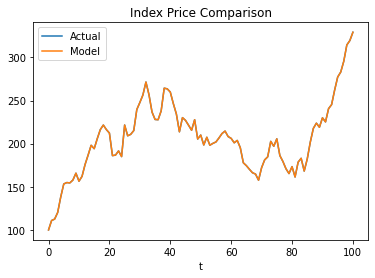

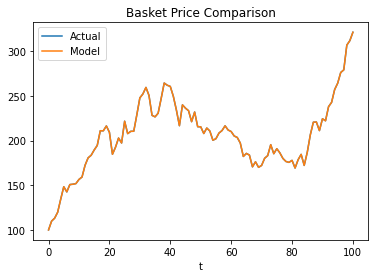

Input notebook does not contain a cell with tag 'parameters'


Executing:   0%|          | 0/7 [00:00<?, ?cell/s]

In [28]:
"""
New code for running
"""

print(arb_dt.mse_backtest_difference())
arb_dt.graph_backtest_difference()
arb_dt.create_backtest_reports("templates/Backtest.ipynb")